# LinearRegression model 2017 Zillow

- Columns were divided into 'category' and 'scalar' depending on the data type.
- Column that has rate of NaN of 'category' data lower than 50% is filled most frequent value
- Column that has rate of NaN of 'category' data bigger than 50% is filled 0 value, because it seems that the Column means exist or not
- Columns of 'scalar' are filled with MICE Imputation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.imputation.mice import MICEData

%matplotlib inline

## Load Data

In [2]:
train_2017 = pd.read_csv("train_2017.csv", parse_dates=["transactiondate"])
print(train_2017.shape)
train_2017.tail()

(77613, 3)


,parcelid,logerror,transactiondate
77608,10833991,-0.002245,2017-09-20
77609,11000655,0.020615,2017-09-20
77610,17239384,0.013209,2017-09-21
77611,12773139,0.037129,2017-09-21
77612,12826780,0.007204,2017-09-25


In [3]:
property_2017 = pd.read_csv("properties_2017.csv", low_memory=False)
print(property_2017.shape)
property_2017.tail()

(2985217, 58)


,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
2985212,12170430,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2985213,11422430,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2985214,17203030,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2985215,14242830,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2985216,12766630,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Preprocessing

### parse date

In [4]:
train_2017["transactionyear"] = train_2017["transactiondate"].dt.year
train_2017["transactionmonth"] = train_2017["transactiondate"].dt.month
train_2017["transactionday"] = train_2017["transactiondate"].dt.day

train_2017.head()

,parcelid,logerror,transactiondate,transactionyear,transactionmonth,transactionday
0,14297519,0.025595,2017-01-01,2017,1,1
1,17052889,0.055619,2017-01-01,2017,1,1
2,14186244,0.005383,2017-01-01,2017,1,1
3,12177905,-0.103410,2017-01-01,2017,1,1
4,10887214,0.006940,2017-01-01,2017,1,1


### join data ( train_2017 & property_2017 )
- make train data

In [5]:
train = train_2017.set_index("parcelid").join(property_2017.set_index("parcelid"))
print(train.shape)
train.head()

(77613, 62)


,logerror,transactiondate,transactionyear,transactionmonth,transactionday,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
parcelid,,,,,,,,,,,,,,,,,,,,,
10711855,-0.007357,2017-07-07,2017,7,7,NaN,NaN,NaN,2.0,3.0,...,NaN,NaN,249655.0,624139.0,2016.0,374484.0,7659.36,NaN,NaN,6.037113e+13
10711877,0.021066,2017-08-29,2017,8,29,1.0,NaN,NaN,2.0,4.0,...,NaN,NaN,253000.0,660000.0,2016.0,407000.0,8123.91,NaN,NaN,6.037113e+13
10711888,0.077174,2017-04-04,2017,4,4,1.0,NaN,NaN,2.0,4.0,...,NaN,NaN,257591.0,542923.0,2016.0,285332.0,6673.24,NaN,NaN,6.037113e+13
10711910,-0.041238,2017-03-17,2017,3,17,NaN,NaN,NaN,2.0,3.0,...,NaN,NaN,57968.0,78031.0,2016.0,20063.0,1116.46,NaN,NaN,6.037113e+13
10711923,-0.009496,2017-03-24,2017,3,24,NaN,NaN,NaN,2.0,4.0,...,NaN,NaN,167869.0,415459.0,2016.0,247590.0,5239.85,NaN,NaN,6.037113e+13


### Fill in NaN value - train
- object type value preprocessing
- float, int type value preprocessing

In [6]:
print(len(train.dtypes[train.dtypes == object]))
train.dtypes[train.dtypes == object]

5


hashottuborspa               object
propertycountylandusecode    object
propertyzoningdesc           object
fireplaceflag                object
taxdelinquencyflag           object
dtype: object

In [7]:
object_columns = ["hashottuborspa", "propertycountylandusecode", "propertyzoningdesc", "fireplaceflag", "taxdelinquencyflag"]
print(train[object_columns].shape)
train[object_columns].head()

(77613, 5)


,hashottuborspa,propertycountylandusecode,propertyzoningdesc,fireplaceflag,taxdelinquencyflag
parcelid,,,,,
10711855,NaN,0101,LARE9,NaN,NaN
10711877,NaN,0101,LARE9,NaN,NaN
10711888,NaN,0100,LARE9,NaN,NaN
10711910,NaN,0101,LARE11,NaN,NaN
10711923,NaN,0101,LARE11,NaN,NaN


- hashottuborspa : True or False
- propertycountylandusecode : 240 types
- propertyzoningdesc : 5638 types
- fireplaceflag : True or False
- taxdelinquencyflag : Y / N

**fill nan**
- hashottuborspa : True or False  ----------------------------->    True = 1, NaN = 0(False)
- fireplaceflag : True or False     ----------------------------->   True = 1, NaN = 0(False)
- taxdelinquencyflag : Y / N           ----------------------------->   Y = 1, NaN = 0(N)
- propertycountylandusecode : not yet preprocessing
- propertyzoningdesc : not yet preprocessing

#### hashottuborspa

In [8]:
# hashottuborspa
train.loc[~train["hashottuborspa"].isna(), "hashottuborspa"] = 1
train.loc[train["hashottuborspa"].isna(), "hashottuborspa"] = 0

train[train["hashottuborspa"].isna()]

,logerror,transactiondate,transactionyear,transactionmonth,transactionday,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
parcelid,,,,,,,,,,,,,,,,,,,,,


#### fireplaceflag

In [9]:
# fireplaceflag
train.loc[~train["fireplaceflag"].isna(), "fireplaceflag"] = 1
train.loc[train["fireplaceflag"].isna(), "fireplaceflag"] = 0

train[train["fireplaceflag"].isna()]

,logerror,transactiondate,transactionyear,transactionmonth,transactionday,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
parcelid,,,,,,,,,,,,,,,,,,,,,


#### taxdelinquencyflag

In [10]:
# taxdelinquencyflag
train.loc[~train["taxdelinquencyflag"].isna(), "taxdelinquencyflag"] = 1
train.loc[train["taxdelinquencyflag"].isna(), "taxdelinquencyflag"] = 0

train[train["taxdelinquencyflag"].isna()]

,logerror,transactiondate,transactionyear,transactionmonth,transactionday,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
parcelid,,,,,,,,,,,,,,,,,,,,,


In [11]:
train[object_columns].dtypes

hashottuborspa                int64
propertycountylandusecode    object
propertyzoningdesc           object
fireplaceflag                 int64
taxdelinquencyflag            int64
dtype: object

In [12]:
print(len(train.dtypes[train.dtypes != object]))
train.dtypes[train.dtypes != object]

60


logerror                               float64
transactiondate                 datetime64[ns]
transactionyear                          int64
transactionmonth                         int64
transactionday                           int64
airconditioningtypeid                  float64
architecturalstyletypeid               float64
basementsqft                           float64
bathroomcnt                            float64
bedroomcnt                             float64
buildingclasstypeid                    float64
buildingqualitytypeid                  float64
calculatedbathnbr                      float64
decktypeid                             float64
finishedfloor1squarefeet               float64
calculatedfinishedsquarefeet           float64
finishedsquarefeet12                   float64
finishedsquarefeet13                   float64
finishedsquarefeet15                   float64
finishedsquarefeet50                   float64
finishedsquarefeet6                    float64
fips         

### Divide column 'Category' and 'Scalar'
- All of assessmentyear value is 2015.0, it means that assessmentyear has not effect for logerror

In [13]:
execept_columns = ["assessmentyear", "propertycountylandusecode", "propertyzoningdesc"]

category_columns = ["airconditioningtypeid", "architecturalstyletypeid", "buildingclasstypeid",\
                    "buildingqualitytypeid", "decktypeid", "fips", "fireplaceflag", "hashottuborspa",\
                    "heatingorsystemtypeid", "pooltypeid10", "pooltypeid2", "pooltypeid7",\
                    "propertylandusetypeid", "rawcensustractandblock", "censustractandblock",\
                    "regionidcounty", "regionidcity", "regionidzip", "regionidneighborhood", "storytypeid",\
                    "typeconstructiontypeid", "unitcnt", "yearbuilt", "taxdelinquencyflag", "taxdelinquencyyear"]

scalar_columns = ["basementsqft", "bathroomcnt", "bedroomcnt", "calculatedbathnbr", "threequarterbathnbr",\
                  "finishedfloor1squarefeet", "calculatedfinishedsquarefeet", "finishedsquarefeet6", "finishedsquarefeet12",\
                  "finishedsquarefeet13", "finishedsquarefeet15", "finishedsquarefeet50", "fireplacecnt",\
                  "fullbathcnt", "garagecarcnt", "garagetotalsqft", "latitude", "longitude", "lotsizesquarefeet",\
                  "numberofstories", "poolcnt", "poolsizesum", "roomcnt", "yardbuildingsqft17", "yardbuildingsqft26",\
                  "taxvaluedollarcnt", "structuretaxvaluedollarcnt", "landtaxvaluedollarcnt", "taxamount"]

dates_columns = ["transactionyear", "transactionmonth", "transactionday"]

len(execept_columns) + len(category_columns) + len(scalar_columns) + len(dates_columns) # + logerror , transactiondate

60

### Category

In [14]:
print(train[category_columns].shape)
train[category_columns].head()

(77613, 25)


,airconditioningtypeid,architecturalstyletypeid,buildingclasstypeid,buildingqualitytypeid,decktypeid,fips,fireplaceflag,hashottuborspa,heatingorsystemtypeid,pooltypeid10,...,regionidcounty,regionidcity,regionidzip,regionidneighborhood,storytypeid,typeconstructiontypeid,unitcnt,yearbuilt,taxdelinquencyflag,taxdelinquencyyear
parcelid,,,,,,,,,,,,,,,,,,,,,
10711855,NaN,NaN,NaN,8.0,NaN,6037.0,0,0,2.0,NaN,...,3101.0,12447.0,96339.0,268588.0,NaN,NaN,1.0,1972.0,0,NaN
10711877,1.0,NaN,NaN,8.0,NaN,6037.0,0,0,2.0,NaN,...,3101.0,12447.0,96339.0,268588.0,NaN,NaN,1.0,1972.0,0,NaN
10711888,1.0,NaN,NaN,8.0,NaN,6037.0,0,0,2.0,NaN,...,3101.0,12447.0,96339.0,268588.0,NaN,NaN,1.0,1972.0,0,NaN
10711910,NaN,NaN,NaN,8.0,NaN,6037.0,0,0,2.0,NaN,...,3101.0,12447.0,96339.0,268588.0,NaN,NaN,1.0,1960.0,0,NaN
10711923,NaN,NaN,NaN,8.0,NaN,6037.0,0,0,2.0,NaN,...,3101.0,12447.0,96339.0,268588.0,NaN,NaN,1.0,1960.0,0,NaN


### Category type datas are filled using most frequent value, if rate of NaN is over 50% of data, then NaN impute 0.

In [15]:
nan_c_train = train[category_columns].isnull().sum(axis=0).reset_index()
nan_c_train.columns = ["column_name", "missing_counts"]
nan_c_train = nan_c_train.sort_values(by="missing_counts")

Text(0.5,1,'Number of missing values in each category column')

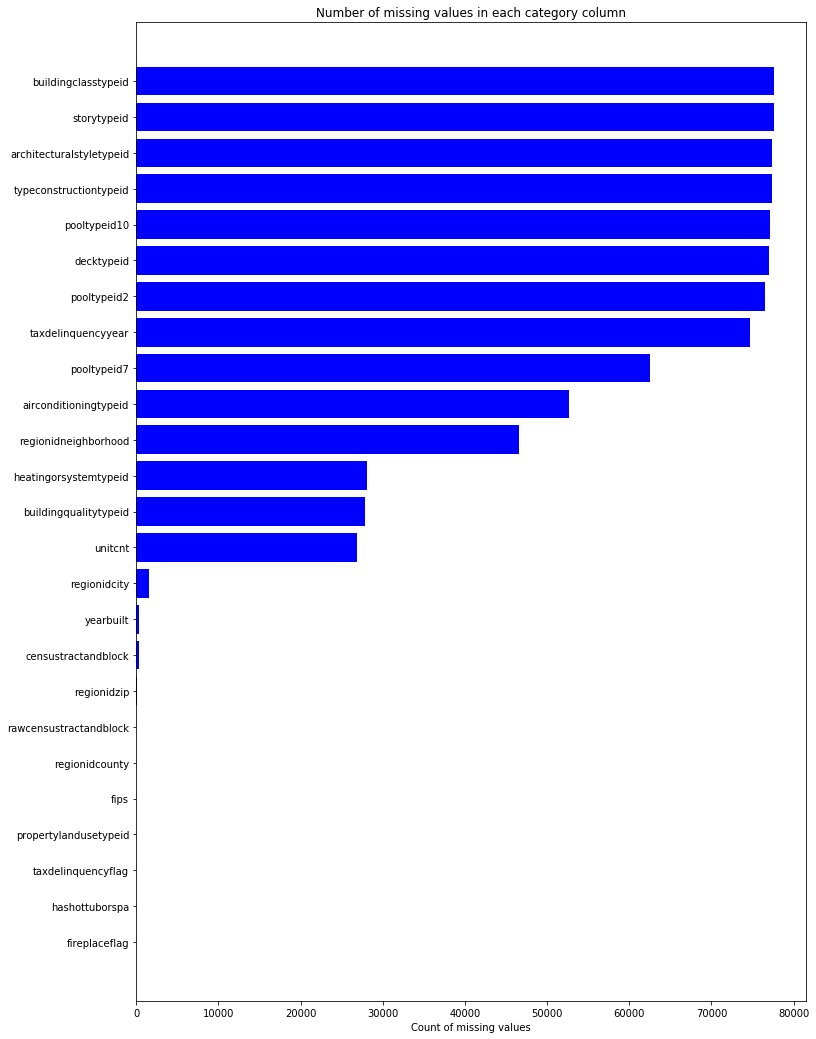

In [16]:
fig, ax = plt.subplots(figsize=(12,18))
ax.barh(np.arange(nan_c_train.shape[0]), nan_c_train.missing_counts.values, color='blue')
ax.set_yticks(np.arange(nan_c_train.shape[0]))
ax.set_yticklabels(nan_c_train.column_name.values, rotation="horizontal")
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each category column")

In [17]:
nan_c_train["rateofNaN"] = nan_c_train["missing_counts"] / 90275
nan_c_train[nan_c_train["rateofNaN"] > 0.5]

,column_name,missing_counts,rateofNaN
18,regionidneighborhood,46639,0.516633
0,airconditioningtypeid,52606,0.582731
11,pooltypeid7,62534,0.692706
24,taxdelinquencyyear,74713,0.827616
10,pooltypeid2,76539,0.847843
4,decktypeid,76999,0.852938
9,pooltypeid10,77148,0.854589
20,typeconstructiontypeid,77390,0.857269
1,architecturalstyletypeid,77406,0.857447
19,storytypeid,77563,0.859186


In [18]:
impute_zero_train = nan_c_train[nan_c_train["rateofNaN"] > 0.5]["column_name"].values
impute_zero_train

array(['regionidneighborhood', 'airconditioningtypeid', 'pooltypeid7',
       'taxdelinquencyyear', 'pooltypeid2', 'decktypeid', 'pooltypeid10',
       'typeconstructiontypeid', 'architecturalstyletypeid', 'storytypeid',
       'buildingclasstypeid'], dtype=object)

In [19]:
train[impute_zero_train].isna().sum()

regionidneighborhood        46639
airconditioningtypeid       52606
pooltypeid7                 62534
taxdelinquencyyear          74713
pooltypeid2                 76539
decktypeid                  76999
pooltypeid10                77148
typeconstructiontypeid      77390
architecturalstyletypeid    77406
storytypeid                 77563
buildingclasstypeid         77598
dtype: int64

In [20]:
train[impute_zero_train] = train[impute_zero_train].fillna(0.0)
train[impute_zero_train].isna().sum()

regionidneighborhood        0
airconditioningtypeid       0
pooltypeid7                 0
taxdelinquencyyear          0
pooltypeid2                 0
decktypeid                  0
pooltypeid10                0
typeconstructiontypeid      0
architecturalstyletypeid    0
storytypeid                 0
buildingclasstypeid         0
dtype: int64

### buildingqualitytypeid

In [21]:
train["buildingqualitytypeid"].value_counts()

8.0     14685
6.0     13501
4.0      9508
7.0      5981
9.0      2303
5.0      2099
11.0      933
3.0       335
10.0      313
12.0      116
1.0        26
2.0         9
Name: buildingqualitytypeid, dtype: int64

In [22]:
train.loc[train["buildingqualitytypeid"].isna(), "buildingqualitytypeid"] = 8.0
train[train["buildingqualitytypeid"].isna()]

,logerror,transactiondate,transactionyear,transactionmonth,transactionday,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
parcelid,,,,,,,,,,,,,,,,,,,,,


### heatingorsystemtypeid

In [23]:
train["heatingorsystemtypeid"].value_counts()

2.0     33633
7.0     14107
24.0      850
6.0       777
20.0      104
13.0       60
18.0       23
1.0        13
10.0        3
11.0        1
Name: heatingorsystemtypeid, dtype: int64

In [24]:
train.loc[train["heatingorsystemtypeid"].isna(), "heatingorsystemtypeid"] = 2.0
train[train["heatingorsystemtypeid"].isna()]

,logerror,transactiondate,transactionyear,transactionmonth,transactionday,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
parcelid,,,,,,,,,,,,,,,,,,,,,


### censustractandblock

In [25]:
train["censustractandblock"].value_counts().head()

6.037137e+13    60
6.037277e+13    51
6.059032e+13    44
6.059063e+13    41
6.037920e+13    41
Name: censustractandblock, dtype: int64

In [26]:
train.loc[train["censustractandblock"].isna(), "censustractandblock"] = 6.037137e+13
train[train["censustractandblock"].isna()]

,logerror,transactiondate,transactionyear,transactionmonth,transactionday,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
parcelid,,,,,,,,,,,,,,,,,,,,,


### regionidcity

In [27]:
train["regionidcity"].value_counts().head()

12447.0    18003
46298.0     2596
5534.0      1916
54311.0     1882
52650.0     1670
Name: regionidcity, dtype: int64

In [28]:
train.loc[train["regionidcity"].isna(), "regionidcity"] = 12447.0
train[train["regionidcity"].isna()]

,logerror,transactiondate,transactionyear,transactionmonth,transactionday,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
parcelid,,,,,,,,,,,,,,,,,,,,,


### regionidzip

In [29]:
train["regionidzip"].value_counts().head()

97319.0    825
96987.0    753
97318.0    712
97118.0    616
96974.0    595
Name: regionidzip, dtype: int64

In [30]:
train.loc[train["regionidzip"].isna(), "regionidzip"] = 97319.0
train[train["regionidzip"].isna()]

,logerror,transactiondate,transactionyear,transactionmonth,transactionday,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
parcelid,,,,,,,,,,,,,,,,,,,,,


### unitcnt

In [31]:
train["unitcnt"].value_counts()

1.0      47413
2.0       2031
4.0        726
3.0        529
6.0          1
45.0         1
237.0        1
42.0         1
Name: unitcnt, dtype: int64

In [32]:
train.loc[train["unitcnt"].isna(), "unitcnt"] = 1.0
train[train["unitcnt"].isna()]

,logerror,transactiondate,transactionyear,transactionmonth,transactionday,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
parcelid,,,,,,,,,,,,,,,,,,,,,


### yearbuilt

In [33]:
train["yearbuilt"].value_counts().head()

1955.0    1975
1989.0    1788
1950.0    1676
1964.0    1648
1954.0    1590
Name: yearbuilt, dtype: int64

In [34]:
train.loc[train["yearbuilt"].isna(), "yearbuilt"] = 1955.0
train[train["yearbuilt"].isna()]

,logerror,transactiondate,transactionyear,transactionmonth,transactionday,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
parcelid,,,,,,,,,,,,,,,,,,,,,


### fips

In [35]:
train["fips"].value_counts().head()

6037.0    50696
6059.0    20631
6111.0     6252
Name: fips, dtype: int64

In [36]:
train.loc[train["fips"].isna(), "fips"] = 6037.0
train[train["fips"].isna()]

,logerror,transactiondate,transactionyear,transactionmonth,transactionday,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
parcelid,,,,,,,,,,,,,,,,,,,,,


### propertylandusetypeid

In [37]:
train["propertylandusetypeid"].value_counts().head()

261.0    52441
266.0    19342
246.0     2021
269.0     1947
248.0      729
Name: propertylandusetypeid, dtype: int64

In [38]:
train.loc[train["propertylandusetypeid"].isna(), "propertylandusetypeid"] = 261.0
train[train["propertylandusetypeid"].isna()]

,logerror,transactiondate,transactionyear,transactionmonth,transactionday,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
parcelid,,,,,,,,,,,,,,,,,,,,,


### rawcensustractandblock

In [39]:
train["rawcensustractandblock"].value_counts().head()

6.059063e+07    60
6.037137e+07    60
6.037920e+07    58
6.037277e+07    51
6.059032e+07    43
Name: rawcensustractandblock, dtype: int64

In [40]:
train.loc[train["rawcensustractandblock"].isna(), "rawcensustractandblock"] = 6.059063e+07
train[train["rawcensustractandblock"].isna()]

,logerror,transactiondate,transactionyear,transactionmonth,transactionday,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
parcelid,,,,,,,,,,,,,,,,,,,,,


### regionidcounty

In [41]:
train["regionidcounty"].value_counts().head()

3101.0    50696
1286.0    20631
2061.0     6252
Name: regionidcounty, dtype: int64

In [42]:
train.loc[train["regionidcounty"].isna(), "regionidcounty"] = 3101.0
train[train["regionidcounty"].isna()]

,logerror,transactiondate,transactionyear,transactionmonth,transactionday,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
parcelid,,,,,,,,,,,,,,,,,,,,,


In [43]:
train[category_columns].isna().sum()

airconditioningtypeid       0
architecturalstyletypeid    0
buildingclasstypeid         0
buildingqualitytypeid       0
decktypeid                  0
fips                        0
fireplaceflag               0
hashottuborspa              0
heatingorsystemtypeid       0
pooltypeid10                0
pooltypeid2                 0
pooltypeid7                 0
propertylandusetypeid       0
rawcensustractandblock      0
censustractandblock         0
regionidcounty              0
regionidcity                0
regionidzip                 0
regionidneighborhood        0
storytypeid                 0
typeconstructiontypeid      0
unitcnt                     0
yearbuilt                   0
taxdelinquencyflag          0
taxdelinquencyyear          0
dtype: int64

### Scalar type data impute using MICE

#### MICEData delete tuples which have no value. (all of value of tuples is NaN), so Fill it with the most frequent value in advance.

In [44]:
print(train[scalar_columns].isna().T.all().sum())

for col_name in scalar_columns:
    train.loc[train[scalar_columns].isna().T.all(), col_name] = property_2017[col_name].mode()[0]
    
train.loc[train[scalar_columns].isna().T.all(), scalar_columns]

34


,basementsqft,bathroomcnt,bedroomcnt,calculatedbathnbr,threequarterbathnbr,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet6,finishedsquarefeet12,finishedsquarefeet13,...,numberofstories,poolcnt,poolsizesum,roomcnt,yardbuildingsqft17,yardbuildingsqft26,taxvaluedollarcnt,structuretaxvaluedollarcnt,landtaxvaluedollarcnt,taxamount
parcelid,,,,,,,,,,,,,,,,,,,,,


In [45]:
imp = MICEData(train[scalar_columns])

In [46]:
imp.data.index = train.index
s_train = imp.data
s_train.head()

,basementsqft,bathroomcnt,bedroomcnt,calculatedbathnbr,threequarterbathnbr,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet6,finishedsquarefeet12,finishedsquarefeet13,...,numberofstories,poolcnt,poolsizesum,roomcnt,yardbuildingsqft17,yardbuildingsqft26,taxvaluedollarcnt,structuretaxvaluedollarcnt,landtaxvaluedollarcnt,taxamount
parcelid,,,,,,,,,,,,,,,,,,,,,
10711855,111.071429,2.0,3.0,2.0,0.009598,0.165314,2107.0,5.5,2107.0,3.238095,...,0.434286,1.0,0.069045,0.0,0.539072,0.385714,624139.0,249655.0,374484.0,7659.36
10711877,111.071429,2.0,4.0,2.0,0.009598,0.165314,1882.0,5.5,1882.0,3.238095,...,0.434286,1.0,0.069045,0.0,0.539072,0.385714,660000.0,253000.0,407000.0,8123.91
10711888,111.071429,2.0,4.0,2.0,0.009598,0.165314,1882.0,5.5,1882.0,3.238095,...,0.434286,0.0,0.069045,0.0,0.539072,0.385714,542923.0,257591.0,285332.0,6673.24
10711910,111.071429,2.0,3.0,2.0,0.009598,0.165314,1477.0,5.5,1477.0,3.238095,...,0.434286,1.0,0.069045,0.0,0.539072,0.385714,78031.0,57968.0,20063.0,1116.46
10711923,111.071429,2.0,4.0,2.0,0.009598,0.165314,1918.0,5.5,1918.0,3.238095,...,0.434286,1.0,0.069045,0.0,0.539072,0.385714,415459.0,167869.0,247590.0,5239.85


### Poolcnt only has one value, therefore fill with 0.0 in NaN value column

In [47]:
train["poolcnt"].value_counts()

1.0    16174
Name: poolcnt, dtype: int64

In [48]:
s_train.loc[train["poolcnt"].isna(), "poolcnt"] = 0.0

In [49]:
X_train = pd.concat([train[category_columns], s_train], axis=1)
print(X_train.shape)
print(X_train.isna().sum())
X_train.head()

(77613, 54)
airconditioningtypeid           0
architecturalstyletypeid        0
buildingclasstypeid             0
buildingqualitytypeid           0
decktypeid                      0
fips                            0
fireplaceflag                   0
hashottuborspa                  0
heatingorsystemtypeid           0
pooltypeid10                    0
pooltypeid2                     0
pooltypeid7                     0
propertylandusetypeid           0
rawcensustractandblock          0
censustractandblock             0
regionidcounty                  0
regionidcity                    0
regionidzip                     0
regionidneighborhood            0
storytypeid                     0
typeconstructiontypeid          0
unitcnt                         0
yearbuilt                       0
taxdelinquencyflag              0
taxdelinquencyyear              0
basementsqft                    0
bathroomcnt                     0
bedroomcnt                      0
calculatedbathnbr               0
th

,airconditioningtypeid,architecturalstyletypeid,buildingclasstypeid,buildingqualitytypeid,decktypeid,fips,fireplaceflag,hashottuborspa,heatingorsystemtypeid,pooltypeid10,...,numberofstories,poolcnt,poolsizesum,roomcnt,yardbuildingsqft17,yardbuildingsqft26,taxvaluedollarcnt,structuretaxvaluedollarcnt,landtaxvaluedollarcnt,taxamount
parcelid,,,,,,,,,,,,,,,,,,,,,
10711855,0.0,0.0,0.0,8.0,0.0,6037.0,0,0,2.0,0.0,...,0.434286,1.0,0.069045,0.0,0.539072,0.385714,624139.0,249655.0,374484.0,7659.36
10711877,1.0,0.0,0.0,8.0,0.0,6037.0,0,0,2.0,0.0,...,0.434286,1.0,0.069045,0.0,0.539072,0.385714,660000.0,253000.0,407000.0,8123.91
10711888,1.0,0.0,0.0,8.0,0.0,6037.0,0,0,2.0,0.0,...,0.434286,0.0,0.069045,0.0,0.539072,0.385714,542923.0,257591.0,285332.0,6673.24
10711910,0.0,0.0,0.0,8.0,0.0,6037.0,0,0,2.0,0.0,...,0.434286,1.0,0.069045,0.0,0.539072,0.385714,78031.0,57968.0,20063.0,1116.46
10711923,0.0,0.0,0.0,8.0,0.0,6037.0,0,0,2.0,0.0,...,0.434286,1.0,0.069045,0.0,0.539072,0.385714,415459.0,167869.0,247590.0,5239.85


### Add dates columns

In [50]:
X_train["logerror"] = train["logerror"].values
X_train["transactionyear"] = train["transactionyear"].values
X_train["transactionmonth"] = train["transactionmonth"].values
X_train["transactionday"] = train["transactionday"].values

### All of columns is filled

In [51]:
X_train.isna().sum().sum()

0

## Visualizaion

- append logerror columns for correlation heatmap

In [52]:
category_columns.append("logerror")
scalar_columns.append("logerror")
dates_columns.append("logerror")

### Category data heatmap for correlation

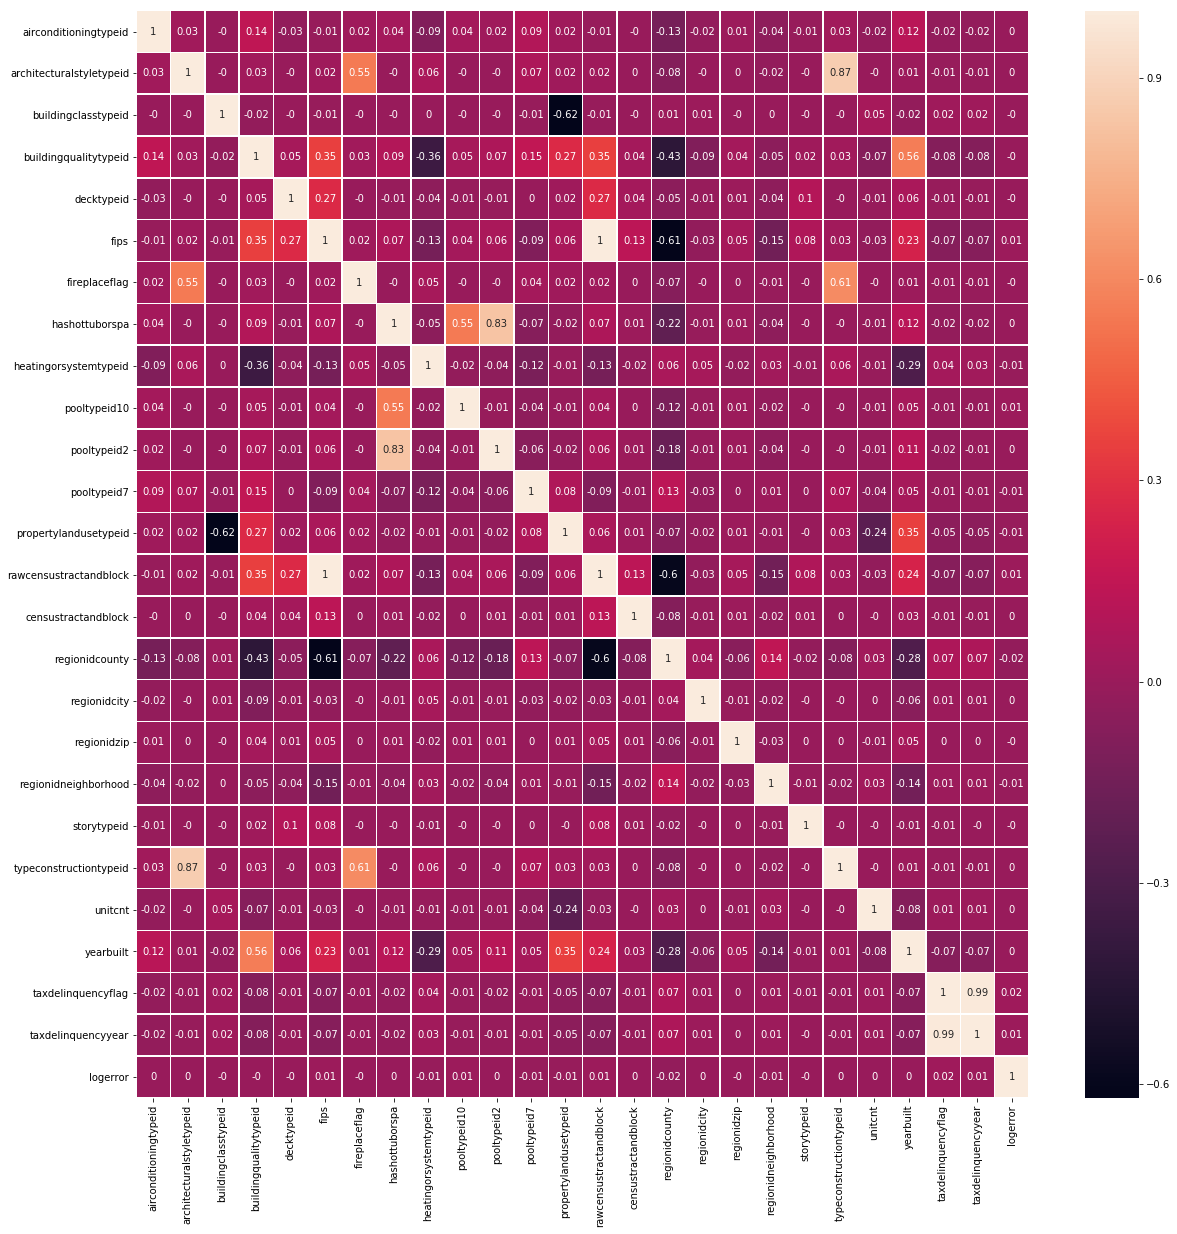

In [53]:
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(round(X_train[category_columns].corr(),2), linewidths=.5, annot=True, ax=ax)

### Scalar value data heatmap for correlation

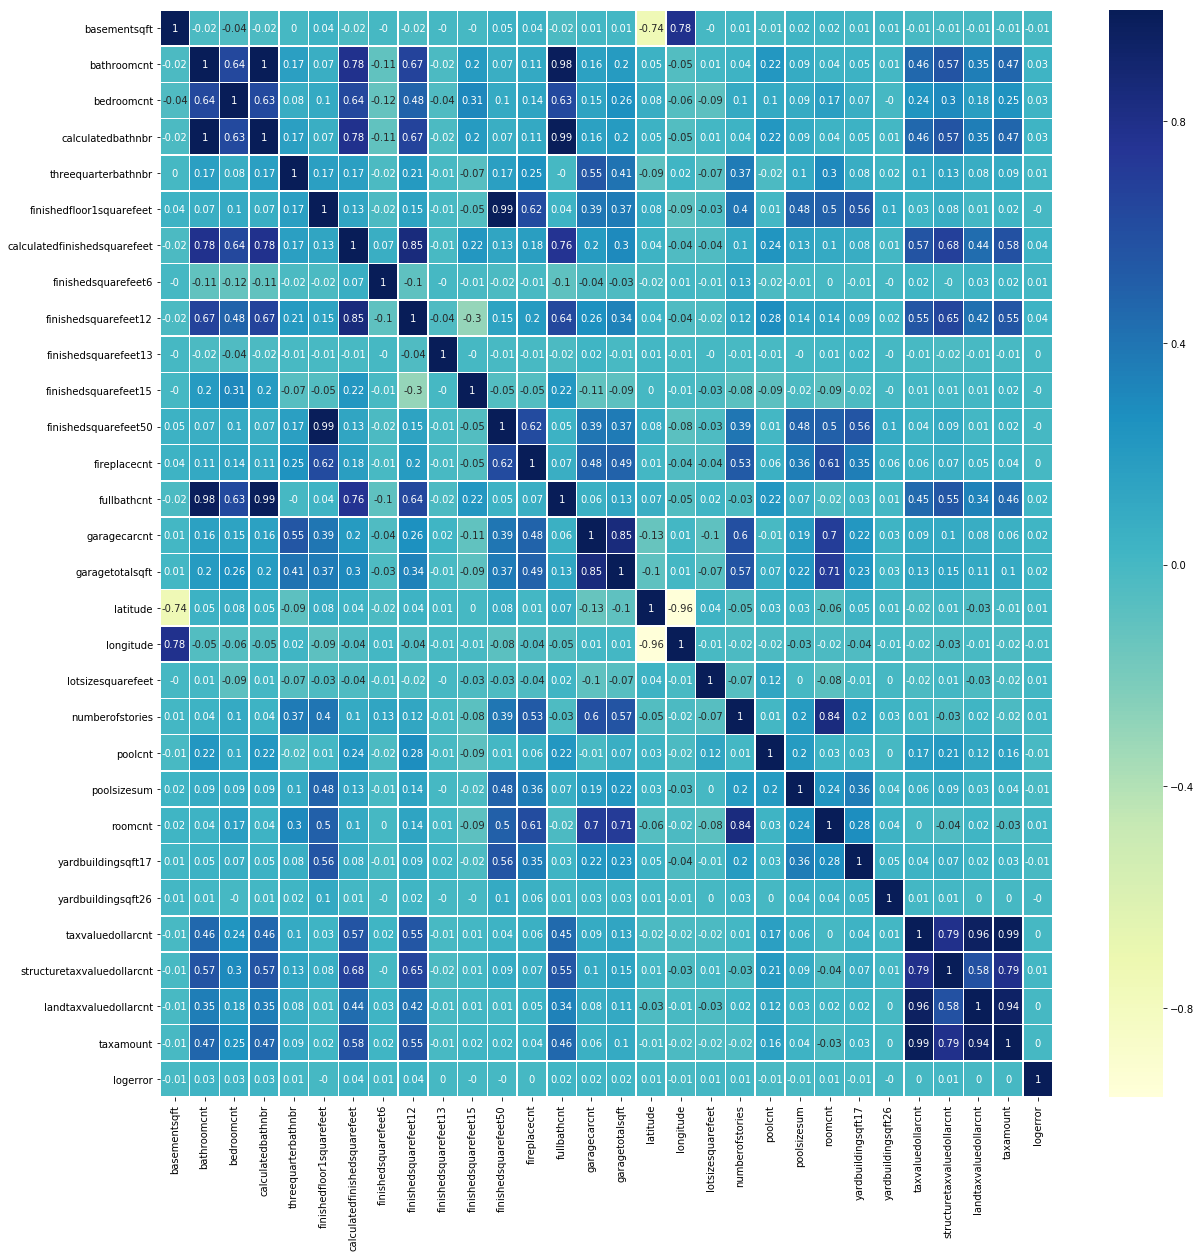

In [54]:
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(round(X_train[scalar_columns].corr(),2), linewidths=.5, annot=True, ax=ax, cmap="YlGnBu")

### Dates data heatmap for correlation

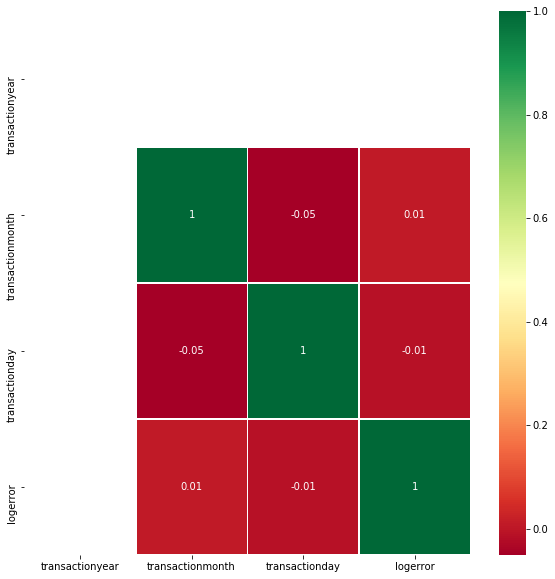

In [55]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(round(X_train[dates_columns].corr(),2), linewidths=.5, annot=True, ax=ax, cmap="RdYlGn")

## Column Selection

### Correlation between logerror and specific column is 0, the column isn't selected for training

In [56]:
zero_category_corr = ["airconditioningtypeid", "architecturalstyletypeid", "buildingclasstypeid", "buildingqualitytypeid", "decktypeid", "fireplaceflag",\
                      "hashottuborspa", "pooltypeid2", "censustractandblock", "regionidcity", "regionidzip", "storytypeid", "typeconstructiontypeid",\
                      "unitcnt", "yearbuilt"]

zero_scalar_corr = ["basementsqft", "finishedfloor1squarefeet", "finishedsquarefeet13", "finishedsquarefeet15", "finishedsquarefeet50",\
                    "fireplacecnt", "yardbuildingsqft26", "taxvaluedollarcnt", "landtaxvaluedollarcnt", "taxamount"]

zero_dates_corr = ["transactionyear"]

In [57]:
train_category_col = [col for col in category_columns if col not in zero_category_corr]
train_scalar_col = [col for col in scalar_columns if col not in zero_scalar_corr]
train_dates_col = ["transactionmonth"] # [col for col in dates_columns if col not in zero_dates_corr]

train_columns_list = train_category_col + train_scalar_col

In [58]:
train_columns_list.remove('logerror') # list has two logerror, because we use logerror drawing heatmap above
train_columns_list

['fips',
 'heatingorsystemtypeid',
 'pooltypeid10',
 'pooltypeid7',
 'propertylandusetypeid',
 'rawcensustractandblock',
 'regionidcounty',
 'regionidneighborhood',
 'taxdelinquencyflag',
 'taxdelinquencyyear',
 'bathroomcnt',
 'bedroomcnt',
 'calculatedbathnbr',
 'threequarterbathnbr',
 'calculatedfinishedsquarefeet',
 'finishedsquarefeet6',
 'finishedsquarefeet12',
 'fullbathcnt',
 'garagecarcnt',
 'garagetotalsqft',
 'latitude',
 'longitude',
 'lotsizesquarefeet',
 'numberofstories',
 'poolcnt',
 'poolsizesum',
 'roomcnt',
 'yardbuildingsqft17',
 'structuretaxvaluedollarcnt',
 'logerror']

## X_train

In [59]:
X_train = X_train[train_columns_list]

print(X_train.shape)
X_train.head()

(77613, 30)


,fips,heatingorsystemtypeid,pooltypeid10,pooltypeid7,propertylandusetypeid,rawcensustractandblock,regionidcounty,regionidneighborhood,taxdelinquencyflag,taxdelinquencyyear,...,latitude,longitude,lotsizesquarefeet,numberofstories,poolcnt,poolsizesum,roomcnt,yardbuildingsqft17,structuretaxvaluedollarcnt,logerror
parcelid,,,,,,,,,,,,,,,,,,,,,
10711855,6037.0,2.0,0.0,1.0,261.0,6.037113e+07,3101.0,268588.0,0,0.0,...,34222559.0,-118617387.0,9158.0,0.434286,1.0,0.069045,0.0,0.539072,249655.0,-0.007357
10711877,6037.0,2.0,0.0,1.0,261.0,6.037113e+07,3101.0,268588.0,0,0.0,...,34220261.0,-118616409.0,9035.0,0.434286,1.0,0.069045,0.0,0.539072,253000.0,0.021066
10711888,6037.0,2.0,0.0,0.0,261.0,6.037113e+07,3101.0,268588.0,0,0.0,...,34222491.0,-118616854.0,9800.0,0.434286,0.0,0.069045,0.0,0.539072,257591.0,0.077174
10711910,6037.0,2.0,0.0,1.0,261.0,6.037113e+07,3101.0,268588.0,0,0.0,...,34221864.0,-118615739.0,11285.0,0.434286,1.0,0.069045,0.0,0.539072,57968.0,-0.041238
10711923,6037.0,2.0,0.0,1.0,261.0,6.037113e+07,3101.0,268588.0,0,0.0,...,34220619.0,-118615253.0,11239.0,0.434286,1.0,0.069045,0.0,0.539072,167869.0,-0.009496


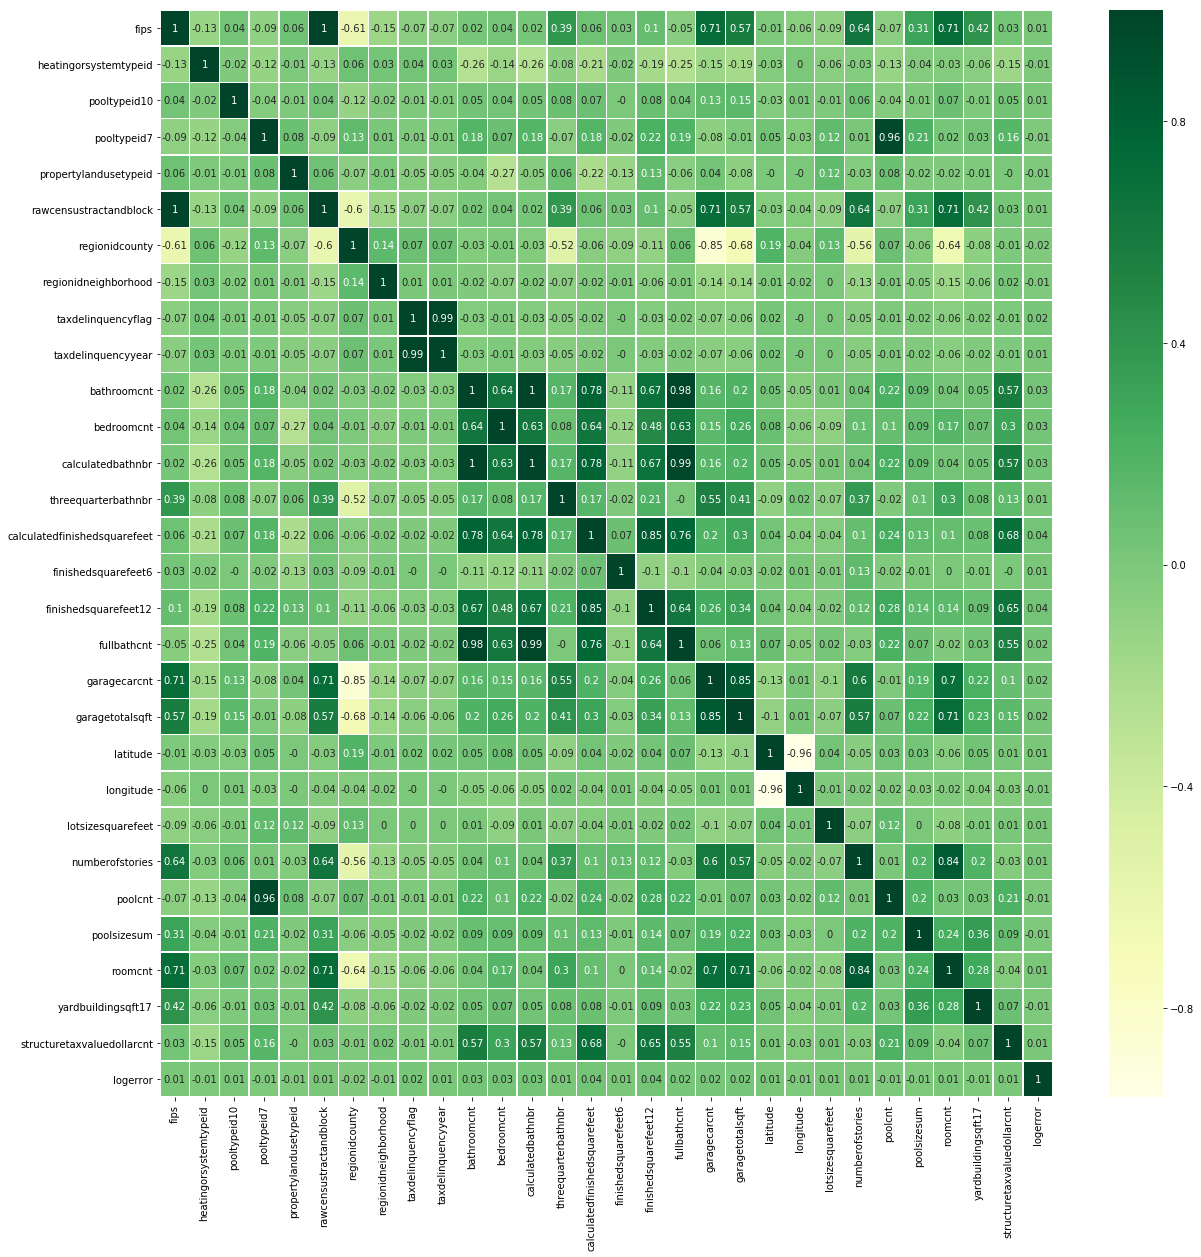

In [60]:
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(round(X_train.corr(),2), linewidths=.5, annot=True, ax=ax, cmap="YlGn")

In [61]:
len(X_train[round(X_train.corr(),2) > 0.0099].columns)

30

In [62]:
X_train.describe()

,fips,heatingorsystemtypeid,pooltypeid10,pooltypeid7,propertylandusetypeid,rawcensustractandblock,regionidcounty,regionidneighborhood,taxdelinquencyflag,taxdelinquencyyear,...,latitude,longitude,lotsizesquarefeet,numberofstories,poolcnt,poolsizesum,roomcnt,yardbuildingsqft17,structuretaxvaluedollarcnt,logerror
count,77613.000000,77613.000000,77613.000000,77613.000000,77613.000000,7.761300e+04,77613.000000,77613.000000,77613.000000,77613.000000,...,7.761300e+04,7.761300e+04,7.761300e+04,77613.000000,77613.000000,77613.000000,77613.000000,77613.000000,7.761300e+04,77613.000000
mean,6048.808975,3.227410,0.005991,0.194284,261.824115,6.049129e+07,2534.763094,74917.830441,0.037365,0.526407,...,3.399347e+07,-1.181520e+08,2.677151e+04,0.661039,0.208393,5.867326,1.475838,9.940564,1.889177e+05,0.016755
std,20.744181,3.017562,0.077172,0.395651,5.140499,2.058616e+05,801.360026,139004.092509,0.189655,2.704972,...,7.594667e+05,2.499459e+06,1.168993e+05,0.492511,0.406162,56.949877,2.823145,67.341946,2.303385e+05,0.170887
min,6037.000000,1.000000,0.000000,0.000000,31.000000,6.037101e+07,1286.000000,0.000000,0.000000,0.000000,...,2.406062e+01,-1.194754e+08,3.437010e+00,0.434286,0.000000,0.069045,0.000000,0.539072,8.459413e-02,-4.655420
25%,6037.000000,2.000000,0.000000,0.000000,261.000000,6.037311e+07,1286.000000,0.000000,0.000000,0.000000,...,3.381432e+07,-1.184150e+08,5.004000e+03,0.434286,0.000000,0.069045,0.000000,0.539072,8.394100e+04,-0.024325
50%,6037.000000,2.000000,0.000000,0.000000,261.000000,6.037603e+07,3101.000000,0.000000,0.000000,0.000000,...,3.402188e+07,-1.181808e+08,6.804000e+03,0.434286,0.000000,0.069045,0.000000,0.539072,1.361880e+05,0.006670
75%,6059.000000,2.000000,0.000000,0.000000,266.000000,6.059042e+07,3101.000000,54300.000000,0.000000,0.000000,...,3.417421e+07,-1.179282e+08,1.051200e+04,0.434286,0.000000,0.069045,0.000000,0.539072,2.184020e+05,0.039295
max,6111.000000,24.000000,1.000000,1.000000,275.000000,6.111009e+07,3101.000000,764167.000000,1.000000,99.000000,...,3.481877e+07,1.479903e+01,6.971010e+06,6.000000,1.000000,1500.000000,15.000000,3191.000000,1.142179e+07,5.262999


## X_test

In [63]:
print(train_category_col)

['fips', 'heatingorsystemtypeid', 'pooltypeid10', 'pooltypeid7', 'propertylandusetypeid', 'rawcensustractandblock', 'regionidcounty', 'regionidneighborhood', 'taxdelinquencyflag', 'taxdelinquencyyear', 'logerror']


In [64]:
print(train_scalar_col)

['bathroomcnt', 'bedroomcnt', 'calculatedbathnbr', 'threequarterbathnbr', 'calculatedfinishedsquarefeet', 'finishedsquarefeet6', 'finishedsquarefeet12', 'fullbathcnt', 'garagecarcnt', 'garagetotalsqft', 'latitude', 'longitude', 'lotsizesquarefeet', 'numberofstories', 'poolcnt', 'poolsizesum', 'roomcnt', 'yardbuildingsqft17', 'structuretaxvaluedollarcnt', 'logerror']


In [65]:
# test data does not need to keep logerror
train_category_col.remove("logerror")
train_scalar_col.remove("logerror")
train_columns_list.remove("logerror")
test_columns_list = train_columns_list

X_test = property_2017[test_columns_list].copy()

### Fill NaN in X_test
- **same way of train data**

In [66]:
print(len(X_test.dtypes[X_test.dtypes == object]))
X_test.dtypes[X_test.dtypes == object]

1


taxdelinquencyflag    object
dtype: object

- hashottuborspa : True or False
- propertycountylandusecode : 240 types
- propertyzoningdesc : 5638 types
- fireplaceflag : True or False
- taxdelinquencyflag : Y / N

**fill nan**
- hashottuborspa : True or False  ----------------------------->    True = 1, NaN = 0(False)
- fireplaceflag : True or False     ----------------------------->   True = 1, NaN = 0(False)
- taxdelinquencyflag : Y / N           ----------------------------->   Y = 1, NaN = 0(N)
- propertycountylandusecode : not yet preprocessing
- propertyzoningdesc : not yet preprocessing

In [67]:
# hashottuborspa is not selected column.
# fireplaceflag is not selected column.

#### taxdelinquencyflag

In [68]:
# taxdelinquencyflag
X_test.loc[~X_test["taxdelinquencyflag"].isna(), "taxdelinquencyflag"] = 1
X_test.loc[X_test["taxdelinquencyflag"].isna(), "taxdelinquencyflag"] = 0

X_test[X_test["taxdelinquencyflag"].isna()]

,fips,heatingorsystemtypeid,pooltypeid10,pooltypeid7,propertylandusetypeid,rawcensustractandblock,regionidcounty,regionidneighborhood,taxdelinquencyflag,taxdelinquencyyear,...,garagetotalsqft,latitude,longitude,lotsizesquarefeet,numberofstories,poolcnt,poolsizesum,roomcnt,yardbuildingsqft17,structuretaxvaluedollarcnt


### Category

In [69]:
print(X_test[train_category_col].shape)
X_test[train_category_col].isna().sum()

(2985217, 10)


fips                         2932
heatingorsystemtypeid     1116053
pooltypeid10              2968211
pooltypeid7               2479322
propertylandusetypeid        2932
rawcensustractandblock       2932
regionidcounty               2932
regionidneighborhood      1828476
taxdelinquencyflag              0
taxdelinquencyyear        2928700
dtype: int64

In [70]:
nan_X_test = X_test[train_category_col].isnull().sum(axis=0).reset_index()
nan_X_test.columns = ["column_name", "missing_counts"]
nan_X_test = nan_X_test.sort_values(by="missing_counts")
nan_X_test["rateofNaN"] = nan_X_test["missing_counts"] / len(X_test)
nan_X_test

,column_name,missing_counts,rateofNaN
8,taxdelinquencyflag,0,0.000000
0,fips,2932,0.000982
4,propertylandusetypeid,2932,0.000982
5,rawcensustractandblock,2932,0.000982
6,regionidcounty,2932,0.000982
1,heatingorsystemtypeid,1116053,0.373860
7,regionidneighborhood,1828476,0.612510
3,pooltypeid7,2479322,0.830533
9,taxdelinquencyyear,2928700,0.981068
2,pooltypeid10,2968211,0.994303


Text(0.5,1,'Number of missing values in each category column')

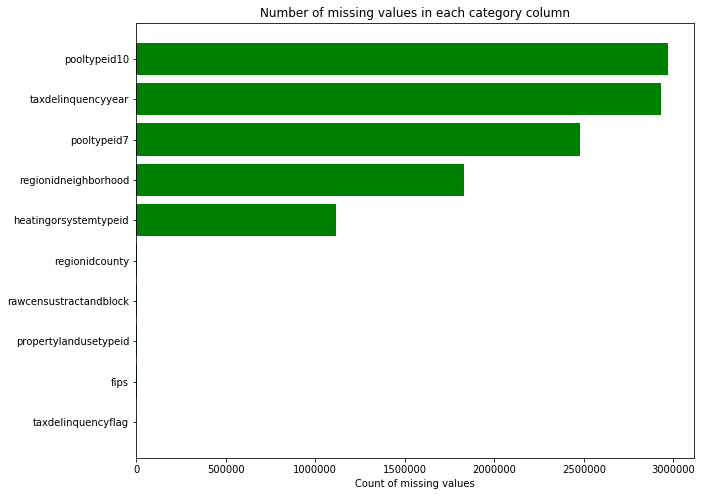

In [71]:
fig, ax = plt.subplots(figsize=(10,8))
ax.barh(np.arange(nan_X_test.shape[0]), nan_X_test.missing_counts.values, color='green')
ax.set_yticks(np.arange(nan_X_test.shape[0]))
ax.set_yticklabels(nan_X_test.column_name.values, rotation="horizontal")
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each category column")

In [72]:
impute_zero_test = nan_X_test[nan_X_test["rateofNaN"] > 0.5]["column_name"].values
impute_zero_test

array(['regionidneighborhood', 'pooltypeid7', 'taxdelinquencyyear',
       'pooltypeid10'], dtype=object)

In [73]:
X_test[impute_zero_test] = X_test[impute_zero_test].fillna(0.0)
X_test[impute_zero_test].isna().sum()

regionidneighborhood    0
pooltypeid7             0
taxdelinquencyyear      0
pooltypeid10            0
dtype: int64

### heatingorsystemtypeid

In [74]:
X_test["heatingorsystemtypeid"].value_counts().head()

2.0     1168610
7.0      646021
6.0       27481
24.0      21107
20.0       3630
Name: heatingorsystemtypeid, dtype: int64

In [75]:
X_test.loc[X_test["heatingorsystemtypeid"].isna(), "heatingorsystemtypeid"] = 2.0
X_test[X_test["heatingorsystemtypeid"].isna()]

,fips,heatingorsystemtypeid,pooltypeid10,pooltypeid7,propertylandusetypeid,rawcensustractandblock,regionidcounty,regionidneighborhood,taxdelinquencyflag,taxdelinquencyyear,...,garagetotalsqft,latitude,longitude,lotsizesquarefeet,numberofstories,poolcnt,poolsizesum,roomcnt,yardbuildingsqft17,structuretaxvaluedollarcnt


### regionidcounty

In [76]:
X_test["regionidcounty"].value_counts().head()

3101.0    2012741
1286.0     745800
2061.0     223744
Name: regionidcounty, dtype: int64

In [77]:
X_test.loc[X_test["regionidcounty"].isna(), "regionidcounty"] = 3101.0
X_test[X_test["regionidcounty"].isna()]

,fips,heatingorsystemtypeid,pooltypeid10,pooltypeid7,propertylandusetypeid,rawcensustractandblock,regionidcounty,regionidneighborhood,taxdelinquencyflag,taxdelinquencyyear,...,garagetotalsqft,latitude,longitude,lotsizesquarefeet,numberofstories,poolcnt,poolsizesum,roomcnt,yardbuildingsqft17,structuretaxvaluedollarcnt


### propertylandusetypeid

In [78]:
X_test["propertylandusetypeid"].value_counts().head()

261.0    2152863
266.0     483789
246.0     114415
269.0      61559
263.0      59344
Name: propertylandusetypeid, dtype: int64

In [79]:
X_test.loc[X_test["propertylandusetypeid"].isna(), "propertylandusetypeid"] = 261.0
X_test[X_test["propertylandusetypeid"].isna()]

,fips,heatingorsystemtypeid,pooltypeid10,pooltypeid7,propertylandusetypeid,rawcensustractandblock,regionidcounty,regionidneighborhood,taxdelinquencyflag,taxdelinquencyyear,...,garagetotalsqft,latitude,longitude,lotsizesquarefeet,numberofstories,poolcnt,poolsizesum,roomcnt,yardbuildingsqft17,structuretaxvaluedollarcnt


### taxdelinquencyflag

In [80]:
X_test["taxdelinquencyflag"].value_counts().head()

0    2928702
1      56515
Name: taxdelinquencyflag, dtype: int64

In [81]:
X_test.loc[X_test["taxdelinquencyflag"].isna(), "taxdelinquencyflag"] = 0
X_test[X_test["taxdelinquencyflag"].isna()]

,fips,heatingorsystemtypeid,pooltypeid10,pooltypeid7,propertylandusetypeid,rawcensustractandblock,regionidcounty,regionidneighborhood,taxdelinquencyflag,taxdelinquencyyear,...,garagetotalsqft,latitude,longitude,lotsizesquarefeet,numberofstories,poolcnt,poolsizesum,roomcnt,yardbuildingsqft17,structuretaxvaluedollarcnt


### rawcensustractandblock

In [82]:
X_test["rawcensustractandblock"].value_counts().head()

6.059052e+07    1576
6.037920e+07    1455
6.059052e+07     971
6.059063e+07     895
6.037137e+07     886
Name: rawcensustractandblock, dtype: int64

In [83]:
X_test.loc[X_test["rawcensustractandblock"].isna(), "rawcensustractandblock"] = 6.059052e+07
X_test[X_test["rawcensustractandblock"].isna()]

,fips,heatingorsystemtypeid,pooltypeid10,pooltypeid7,propertylandusetypeid,rawcensustractandblock,regionidcounty,regionidneighborhood,taxdelinquencyflag,taxdelinquencyyear,...,garagetotalsqft,latitude,longitude,lotsizesquarefeet,numberofstories,poolcnt,poolsizesum,roomcnt,yardbuildingsqft17,structuretaxvaluedollarcnt


### fips

In [84]:
X_test["fips"].value_counts()

6037.0    2012741
6059.0     745800
6111.0     223744
Name: fips, dtype: int64

In [85]:
X_test.loc[X_test["fips"].isna(), "fips"] = 6037.0
X_test[X_test["fips"].isna()]

,fips,heatingorsystemtypeid,pooltypeid10,pooltypeid7,propertylandusetypeid,rawcensustractandblock,regionidcounty,regionidneighborhood,taxdelinquencyflag,taxdelinquencyyear,...,garagetotalsqft,latitude,longitude,lotsizesquarefeet,numberofstories,poolcnt,poolsizesum,roomcnt,yardbuildingsqft17,structuretaxvaluedollarcnt


In [86]:
X_test[train_category_col].isna().sum()

fips                      0
heatingorsystemtypeid     0
pooltypeid10              0
pooltypeid7               0
propertylandusetypeid     0
rawcensustractandblock    0
regionidcounty            0
regionidneighborhood      0
taxdelinquencyflag        0
taxdelinquencyyear        0
dtype: int64

### Scalar

#### MICEData delete tuples which have no value. (all of value of tuples is NaN), so Fill it with the most frequent value in advance.

In [87]:
print(X_test[train_scalar_col].isna().T.all().sum())

for col_name in train_scalar_col:
    X_test.loc[X_test[train_scalar_col].isna().T.all(), col_name] = property_2017[col_name].mode()[0]
    
X_test.loc[X_test[train_scalar_col].isna().T.all(), train_scalar_col]

2932


,bathroomcnt,bedroomcnt,calculatedbathnbr,threequarterbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet6,finishedsquarefeet12,fullbathcnt,garagecarcnt,garagetotalsqft,latitude,longitude,lotsizesquarefeet,numberofstories,poolcnt,poolsizesum,roomcnt,yardbuildingsqft17,structuretaxvaluedollarcnt


In [88]:
imp = MICEData(X_test[train_scalar_col])

In [89]:
imp.data.head()

,bathroomcnt,bedroomcnt,calculatedbathnbr,threequarterbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet6,finishedsquarefeet12,fullbathcnt,garagecarcnt,garagetotalsqft,latitude,longitude,lotsizesquarefeet,numberofstories,poolcnt,poolsizesum,roomcnt,yardbuildingsqft17,structuretaxvaluedollarcnt
0,0.0,0.0,0.196174,0.010611,0.455292,0.444791,0.044992,0.248089,0.173419,0.15622,34144442.0,-118654084.0,85768.0,0.400956,0.0,0.28457,0.0,0.458388,0.112048
1,0.0,0.0,0.196174,0.010611,0.455292,0.444791,0.044992,0.248089,0.173419,0.15622,34140430.0,-118625364.0,4083.0,0.400956,0.0,0.28457,0.0,0.458388,0.112048
2,0.0,0.0,0.196174,0.010611,73026.000000,0.444791,0.044992,0.248089,0.173419,0.15622,33989359.0,-118394633.0,63085.0,1.000000,0.0,0.28457,0.0,0.458388,660680.000000
3,0.0,0.0,0.196174,0.010611,5068.000000,0.444791,0.044992,0.248089,0.173419,0.15622,34148863.0,-118437206.0,7521.0,1.000000,0.0,0.28457,0.0,0.458388,580059.000000
4,0.0,0.0,0.196174,0.010611,1776.000000,0.444791,0.044992,0.248089,0.173419,0.15622,34194168.0,-118385816.0,8512.0,1.000000,0.0,0.28457,0.0,0.458388,196751.000000


In [90]:
imp.data.index = X_test[train_scalar_col].index
s_test = imp.data
s_test.head()

,bathroomcnt,bedroomcnt,calculatedbathnbr,threequarterbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet6,finishedsquarefeet12,fullbathcnt,garagecarcnt,garagetotalsqft,latitude,longitude,lotsizesquarefeet,numberofstories,poolcnt,poolsizesum,roomcnt,yardbuildingsqft17,structuretaxvaluedollarcnt
0,0.0,0.0,0.196174,0.010611,0.455292,0.444791,0.044992,0.248089,0.173419,0.15622,34144442.0,-118654084.0,85768.0,0.400956,0.0,0.28457,0.0,0.458388,0.112048
1,0.0,0.0,0.196174,0.010611,0.455292,0.444791,0.044992,0.248089,0.173419,0.15622,34140430.0,-118625364.0,4083.0,0.400956,0.0,0.28457,0.0,0.458388,0.112048
2,0.0,0.0,0.196174,0.010611,73026.000000,0.444791,0.044992,0.248089,0.173419,0.15622,33989359.0,-118394633.0,63085.0,1.000000,0.0,0.28457,0.0,0.458388,660680.000000
3,0.0,0.0,0.196174,0.010611,5068.000000,0.444791,0.044992,0.248089,0.173419,0.15622,34148863.0,-118437206.0,7521.0,1.000000,0.0,0.28457,0.0,0.458388,580059.000000
4,0.0,0.0,0.196174,0.010611,1776.000000,0.444791,0.044992,0.248089,0.173419,0.15622,34194168.0,-118385816.0,8512.0,1.000000,0.0,0.28457,0.0,0.458388,196751.000000


In [91]:
X_test["poolcnt"].value_counts()

1.0    539632
Name: poolcnt, dtype: int64

In [92]:
s_test.loc[X_test["poolcnt"].isna(), "poolcnt"] = 0.0

In [93]:
X_test = pd.concat([X_test[train_category_col], s_test], axis=1)
print(X_test.shape)
print(X_test.isna().sum())
X_test.head()

(2985217, 29)
fips                            0
heatingorsystemtypeid           0
pooltypeid10                    0
pooltypeid7                     0
propertylandusetypeid           0
rawcensustractandblock          0
regionidcounty                  0
regionidneighborhood            0
taxdelinquencyflag              0
taxdelinquencyyear              0
bathroomcnt                     0
bedroomcnt                      0
calculatedbathnbr               0
threequarterbathnbr             0
calculatedfinishedsquarefeet    0
finishedsquarefeet6             0
finishedsquarefeet12            0
fullbathcnt                     0
garagecarcnt                    0
garagetotalsqft                 0
latitude                        0
longitude                       0
lotsizesquarefeet               0
numberofstories                 0
poolcnt                         0
poolsizesum                     0
roomcnt                         0
yardbuildingsqft17              0
structuretaxvaluedollarcnt      0


,fips,heatingorsystemtypeid,pooltypeid10,pooltypeid7,propertylandusetypeid,rawcensustractandblock,regionidcounty,regionidneighborhood,taxdelinquencyflag,taxdelinquencyyear,...,garagetotalsqft,latitude,longitude,lotsizesquarefeet,numberofstories,poolcnt,poolsizesum,roomcnt,yardbuildingsqft17,structuretaxvaluedollarcnt
0,6037.0,2.0,0.0,0.0,269.0,6.037800e+07,3101.0,0.0,0,0.0,...,0.15622,34144442.0,-118654084.0,85768.0,0.400956,0.0,0.28457,0.0,0.458388,0.112048
1,6037.0,2.0,0.0,0.0,261.0,6.037800e+07,3101.0,0.0,0,0.0,...,0.15622,34140430.0,-118625364.0,4083.0,0.400956,0.0,0.28457,0.0,0.458388,0.112048
2,6037.0,2.0,0.0,0.0,47.0,6.037703e+07,3101.0,0.0,0,0.0,...,0.15622,33989359.0,-118394633.0,63085.0,1.000000,0.0,0.28457,0.0,0.458388,660680.000000
3,6037.0,2.0,0.0,0.0,47.0,6.037141e+07,3101.0,27080.0,0,0.0,...,0.15622,34148863.0,-118437206.0,7521.0,1.000000,0.0,0.28457,0.0,0.458388,580059.000000
4,6037.0,2.0,0.0,0.0,31.0,6.037123e+07,3101.0,46795.0,0,0.0,...,0.15622,34194168.0,-118385816.0,8512.0,1.000000,0.0,0.28457,0.0,0.458388,196751.000000


In [94]:
X_test.isna().sum().sum()

0

## Y_train

In [95]:
y_train = X_train["logerror"]
print(y_train.shape)
y_train[:10]

(77613,)


parcelid
10711855   -0.007357
10711877    0.021066
10711888    0.077174
10711910   -0.041238
10711923   -0.009496
10711945    0.001271
10711956    0.023298
10711995    0.041138
10712005    0.012092
10712007    0.465167
Name: logerror, dtype: float64

## model

In [96]:
# X_train has logerror columns
print(X_train.shape)
print(X_test.shape)

# remove logerror of X_train
X_train.drop("logerror", inplace=True, axis=1)
X_train.shape

(77613, 30)
(2985217, 29)


(77613, 29)

In [97]:
from sklearn.linear_model import LinearRegression

model = LinearRegression(n_jobs=6, normalize=True)

model

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=6, normalize=True)

In [98]:
model.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/base.py:509: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=6, normalize=True)

In [99]:
model.coef_

array([  6.85265250e-03,  -1.10192648e-04,  -2.70031644e-04,
         9.48323565e-03,   1.23251854e-04,  -6.92646105e-07,
         9.77594510e-07,  -1.07219711e-08,   1.27035802e-01,
        -7.87206872e-03,   7.39333108e-02,   2.73921739e-03,
        -9.92473594e-01,   4.64418085e-01,   4.17413381e-06,
        -4.50598284e-06,   7.84615165e-06,   9.17540282e-01,
         1.28810430e-03,   5.01355511e-06,  -3.74946420e-09,
        -1.02268185e-09,   2.68019709e-08,  -4.55243807e-04,
        -1.77212316e-02,  -2.47378665e-05,   1.27630279e-04,
        -2.19402755e-05,  -2.60251984e-08])

In [100]:
predict_y_2017 = model.predict(X_test)
predict_y_2017

array([ 0.02959414,  0.02640519,  0.28996505, ...,  0.03397053,
        0.03397053,  0.03397053])

## submission

In [104]:
submission = pd.read_csv("submission_2016.csv")
submission.head()

,ParcelId,201610,201611,201612,201710,201711,201712
0,10754147,0.015438,0.015438,0.015438,0.015438,0.015438,0.015438
1,10759547,0.015343,0.015343,0.015343,0.015343,0.015343,0.015343
2,10843547,0.583488,0.583488,0.583488,0.583488,0.583488,0.583488
3,10859147,0.052703,0.052703,0.052703,0.052703,0.052703,0.052703
4,10879947,0.029692,0.029692,0.029692,0.029692,0.029692,0.029692


In [105]:
submission["201710"] = predict_y_2017
submission["201711"] = predict_y_2017
submission["201712"] = predict_y_2017

submission.head()

,ParcelId,201610,201611,201612,201710,201711,201712
0,10754147,0.015438,0.015438,0.015438,0.029594,0.029594,0.029594
1,10759547,0.015343,0.015343,0.015343,0.026405,0.026405,0.026405
2,10843547,0.583488,0.583488,0.583488,0.289965,0.289965,0.289965
3,10859147,0.052703,0.052703,0.052703,0.009955,0.009955,0.009955
4,10879947,0.029692,0.029692,0.029692,0.003934,0.003934,0.003934


In [106]:
submission.to_csv("submission_2016_2017.csv", index=False)